In [20]:
import os
import cv2
import math
import pickle
import random
import matplotlib
import numpy as np
import pandas as pd
from pathlib import Path
from threading import Thread
import matplotlib.pyplot as plt
from IPython.display import clear_output
from xgboost.sklearn import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

In [23]:
# get smoky-mountain-data-comp folder
HOME_DIR = str(Path().cwd().parent)

# get the sam data folder
SAM_FOLDER = "seg_from_SAM"

# consistent randmo seed for everything
RANDOM_SEED = 107

# high quality figures
matplotlib.rcParams["figure.dpi"] = 600

# load the spreadsheet into the kernel
SHEET_DATA = pd.read_excel(f"{HOME_DIR}/step1/data.xlsx")
SHEET_DATA.head()

,filename,treatment,block,row,position,genotype
0,EB00CEE6-848F-4E2A-9A56-C0CD83D55630.jpg,D,1.0,8.0,32.0,BESC-34
1,5AF900F9-D701-4994-95AC-2352420BF18F.jpg,C,1.0,10.0,12.0,"**BESC-417_LM**,core"
2,F7D01515-92CA-4AF5-9BD9-3A4CD99EDF42.jpg,C,2.0,3.0,40.0,BESC-468
3,9117861B-2D2B-4EA8-94B1-D0A862914398.jpg,C,2.0,6.0,54.0,BESC-28_LM
4,D1B282CF-2A10-4458-9E3A-FE08E065A3D6.jpg,C,1.0,24.0,22.0,"**LILD-26-5_LM**,core"


Functions and Type Declarations

In [6]:
cv2.Image = np.ndarray
cv2.Contour = np.ndarray

# shows an image on ipynb
def imshow(img: np.ndarray) -> None:
    plt.axis('off')
    plt.grid(False)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

# get a random filename from within the sheet
def get_random_filename() -> str:
    return SHEET_DATA['filename'][random.randint(0, len(SHEET_DATA)-1)]

# display filename and image, and get image going to filename
def get_image_leaf(filename: str = None, show: bool = True):
    if filename is None:
        filename = get_random_filename()
    img = cv2.imread(f"leaves/{filename}")
    if show:
        print(filename)
        imshow(img)
    return img

def get_major_contour(img: cv2.Image) -> cv2.Contour:

    gray = grayscale(img)
    blur = cv2.GaussianBlur(gray, (21, 21), sigmaX=0, sigmaY=0)
    _, thresh = cv2.threshold(blur, 1, 255, cv2.THRESH_BINARY)

    # get the contour of the leaf if there is one
    try:
        contour = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0][0]
    except IndexError:
        return None
    
    return contour

# easy access grayscale function
def grayscale(img: cv2.Image) -> cv2.Image:
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

Gets the features from the leaf (extended previous feature finding)

307F9C13-0AD2-45A3-A361-3237D76763C8.jpg


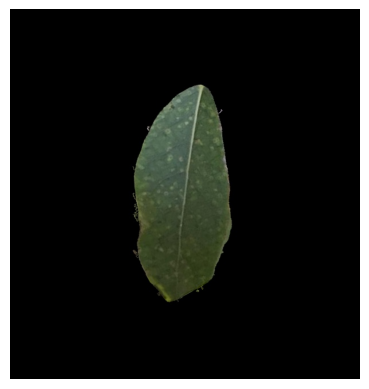

{'area_peri': 0.05424530985331497,
 'area_rect': 0.7561250805931657,
 'area_convex': 0.9721776073778561,
 'area_elli_inter': 0.9747299793931642,
 'ellipse_elli_inter': 0.9585087799873356,
 'area_to_circ': 0.44832409918814103,
 'area_image': 0.14149513494219995,
 'green_area': 0.8008775669722163,
 'h0': 0.6818551418881422,
 'h1': 1.7539333288771686,
 'h2': 4.375004727368296,
 'h3': 5.07495244196774,
 'h4': 9.829571396839123,
 'h5': 6.038837679713217,
 'h6': -10.247018005610768,
 'col_h': 50.34698769697183,
 'col_s': 73.61107977579582,
 'col_v': 61.049123982091864}

In [18]:
def get_features_leaf(img: cv2.Image) -> dict[str, float]:

    GREEN_LOWER = (20, 50, 50)
    GREEN_UPPER = (80, 255, 255)

    # get the leaf contour
    leaf = get_major_contour(img)
    if leaf is None:
        return None

    # get contour moments
    moments = cv2.HuMoments(cv2.moments(leaf))
    adjusted_moments = map(lambda x: -math.copysign(1.0, x) * math.log10(abs(x)), [*moments])
    moment_dict = {f'h{i}': m for i, m in enumerate(adjusted_moments)}

    area = cv2.contourArea(leaf)
    x, y, w, h = cv2.boundingRect(leaf)

    # the idea here is that ratios are more important than the values themselevs
    # get ratio of area to bounding rect, perimeter, and bounding hull
    area_rect_ratio = area / (w * h)
    area_peri_ratio = area / cv2.arcLength(leaf, True) ** 2    # might make it too sensitive :O
    convex_area_ratio = area / cv2.contourArea(cv2.convexHull(leaf))

    # ratio of area covered by fit ellipse to contour
    el_mask, cnt_mask = [np.zeros((y+h*3, x+w*3)) for _ in range(2)]
    ellipse = cv2.fitEllipse(leaf)
    ellipse_area = float(np.prod(ellipse[1])) * math.pi / 4
    el_mask = cv2.ellipse(el_mask, ellipse, 100, thickness=cv2.FILLED)
    cnt_mask = cv2.drawContours(cnt_mask, [leaf], -1, 100, cv2.FILLED)
    total_mask = cv2.threshold((el_mask + cnt_mask).astype(np.uint8), 150, 255, 0)[1]
    merged_contours = cv2.findContours(total_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
    total_merged_area = sum(map(cv2.contourArea, merged_contours))

    # ratio of area (in contour and ellipse) to interesct with bounding ellipse
    area_intersect_ratio = total_merged_area / area
    area_ellipse_intersect_ratio = total_merged_area / ellipse_area

    # get average color - in hsv
    drawn_contour = cv2.drawContours(np.zeros(img.shape[:2], dtype=np.uint8), [leaf], -1, (255), cv2.FILLED)
    mean = cv2.mean(img, mask=drawn_contour)
    avg_colors = {
        label: col_val for label, col_val
        in zip(['col_h', 'col_s', 'col_v'], mean)
    }

    # get ratio of contour area to area of whole image
    area_imagearea_ratio = area / float(np.prod(img.shape[:2]))

    # area of brown splotches 
    only_green = cv2.inRange(cv2.cvtColor(img, cv2.COLOR_BGR2HSV), GREEN_LOWER, GREEN_UPPER)
    green_area = only_green.sum() // 255

    # ratio of green area to whole thing area
    green_area_ratio = green_area / area
    
    # get the ratio of the area of the min enclosing circle to area of contour
    _, radius = cv2.minEnclosingCircle(leaf)
    circle_area = radius**2 * 3.1415926535
    area_to_circle_ratio = area / circle_area

    # return extracted features
    return {
        'area_peri': area_peri_ratio,
        'area_rect': area_rect_ratio,
        'area_convex': convex_area_ratio,
        'area_elli_inter': area_intersect_ratio,
        'ellipse_elli_inter': area_ellipse_intersect_ratio,
        'area_to_circ': area_to_circle_ratio,
        'area_image': area_imagearea_ratio,
        'green_area': green_area_ratio
    } | moment_dict | avg_colors

img = get_image_leaf()
get_features_leaf(img)

Train model subjectively

In [19]:
IMAGE_COUNT = 100
DATA_FOLDER = "morph_model"

if DATA_FOLDER not in os.listdir():
    os.mkdir(DATA_FOLDER)

class FeatureThread(Thread):
    def __init__(self, img: cv2.Image):
        Thread.__init__(self)
        self.leaf = img
        self.features = None
    def run(self):
        self.features = get_features_leaf(self.leaf)

data = []
random.seed(RANDOM_SEED)
files = {*random.choices(os.listdir("leaves"), k=IMAGE_COUNT)}
try:
    for filename in files:

        # get the image and the leaf contours
        leaf = get_image_leaf(filename, show=False)
        if leaf.shape[:2] == (128, 128):
            continue

        # start a thread for feature extraction
        thread = FeatureThread(leaf)
        thread.start()
        imshow(leaf)

        # wait for thread to run during input, join thread, and take data
        color_class = {'dg': 'dark_green', 'lg': 'light_green', 'y': 'yellow', 'yg': 'yellow_green'}[input("What color is this leaf?")]
        shape_class = ['ovate', 'lanceolate', 'elliptical', 'obovate', 'oblanceolate',
                       'oblong', 'linear', 'peltate', 'reniform', 'spatulate'][int(input("What leaf morphology number is this?"))-1]
        splotch_class = ['none', 'low', 'medium', 'high'][int(input("Enter the level of brown splotches you see on the screen"))]

        thread.join()
        data.append(thread.features | {'color': color_class, 'shape': shape_class, 'splotch': splotch_class})
        clear_output()

# store data regardless of exit scenario
finally:
    df = pd.DataFrame(data)
    pd.set_option('display.width', 300)
    print(df.head())
    if DATA_FOLDER not in os.listdir():
        os.mkdir(DATA_FOLDER)
    df.to_csv(f'{DATA_FOLDER}/data.csv', index=False)

   area_peri  area_rect  area_convex  area_elli_inter  ellipse_elli_inter  area_to_circ  area_image  green_area        h0        h1  ...        h3         h4        h5         h6      col_h       col_s       col_v         color       shape splotch
0   0.061711   0.762304     0.981324         0.983802            0.970738      0.589437    0.200855    0.879384  0.742867  2.141855  ...  6.619501 -12.545615 -7.713002  13.227133  21.510662  100.730264  100.180740  yellow_green      oblong     low
1   0.038792   0.673701     0.976217         0.951215            0.923434      0.262250    0.231186    0.930968  0.528923  1.213533  ...  3.219565   6.318330  3.827691   8.065547  37.451820   76.044768   63.187753    dark_green  lanceolate    none
2   0.056377   0.709074     0.966671         0.965582            0.959860      0.519880    0.158231    0.901328  0.733679  2.079237  ...  5.434485  10.446622  6.751127 -10.554237  43.339036   86.421210   74.716978    dark_green  elliptical     low
3   0.05

In [3]:
MODEL_FOLDER = "morph_model"

# get training and testing data
df = pd.read_csv(f"{MODEL_FOLDER}/data.csv")
labels = pd.DataFrame({
    'color': df.pop('color'),
    'shape': df.pop('shape'),
    'splotch': df.pop('splotch')
})

# encode columns to be numerical
la_enc = LabelEncoder()
encoders = {
    'color': LabelEncoder(),
    'shape': LabelEncoder(),
    'splotch': LabelEncoder(),
}

# fit each label encoder
for col in labels.columns:
    labels[col] = encoders[col].fit_transform(labels[col])

# split data
X_train, X_test, y_train, y_test = train_test_split(
    df, labels, test_size=0.30, random_state=RANDOM_SEED
)

# scale data to normailty
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# create, fit, and test model
model = MultiOutputClassifier(XGBClassifier(random_state=RANDOM_SEED))
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_test = np.array(y_test)

# save models
with open(f"{MODEL_FOLDER}/model.pkl", "wb") as f:
    pickle.dump(model, f)
with open(f"{MODEL_FOLDER}/scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)
with open(f"{MODEL_FOLDER}/encoders.pkl", "wb") as f:
    pickle.dump(encoders, f)

# calculate accuracy scores
print("\n".join([
    f"The model's accuracy for {feature} was {acc:.2%}."
    for acc, feature in zip([
        accuracy_score(tru, pred) for [tru, pred]
        in [[y_test[:, i], y_pred[:, i]] for i in range(3)]
    ], labels.keys())
]))

The model's accuracy for color was 69.23%.
The model's accuracy for shape was 50.00%.
The model's accuracy for splotch was 69.23%.


#### Plot Confusion Matrices

Confusion Matrix for Color Predictions

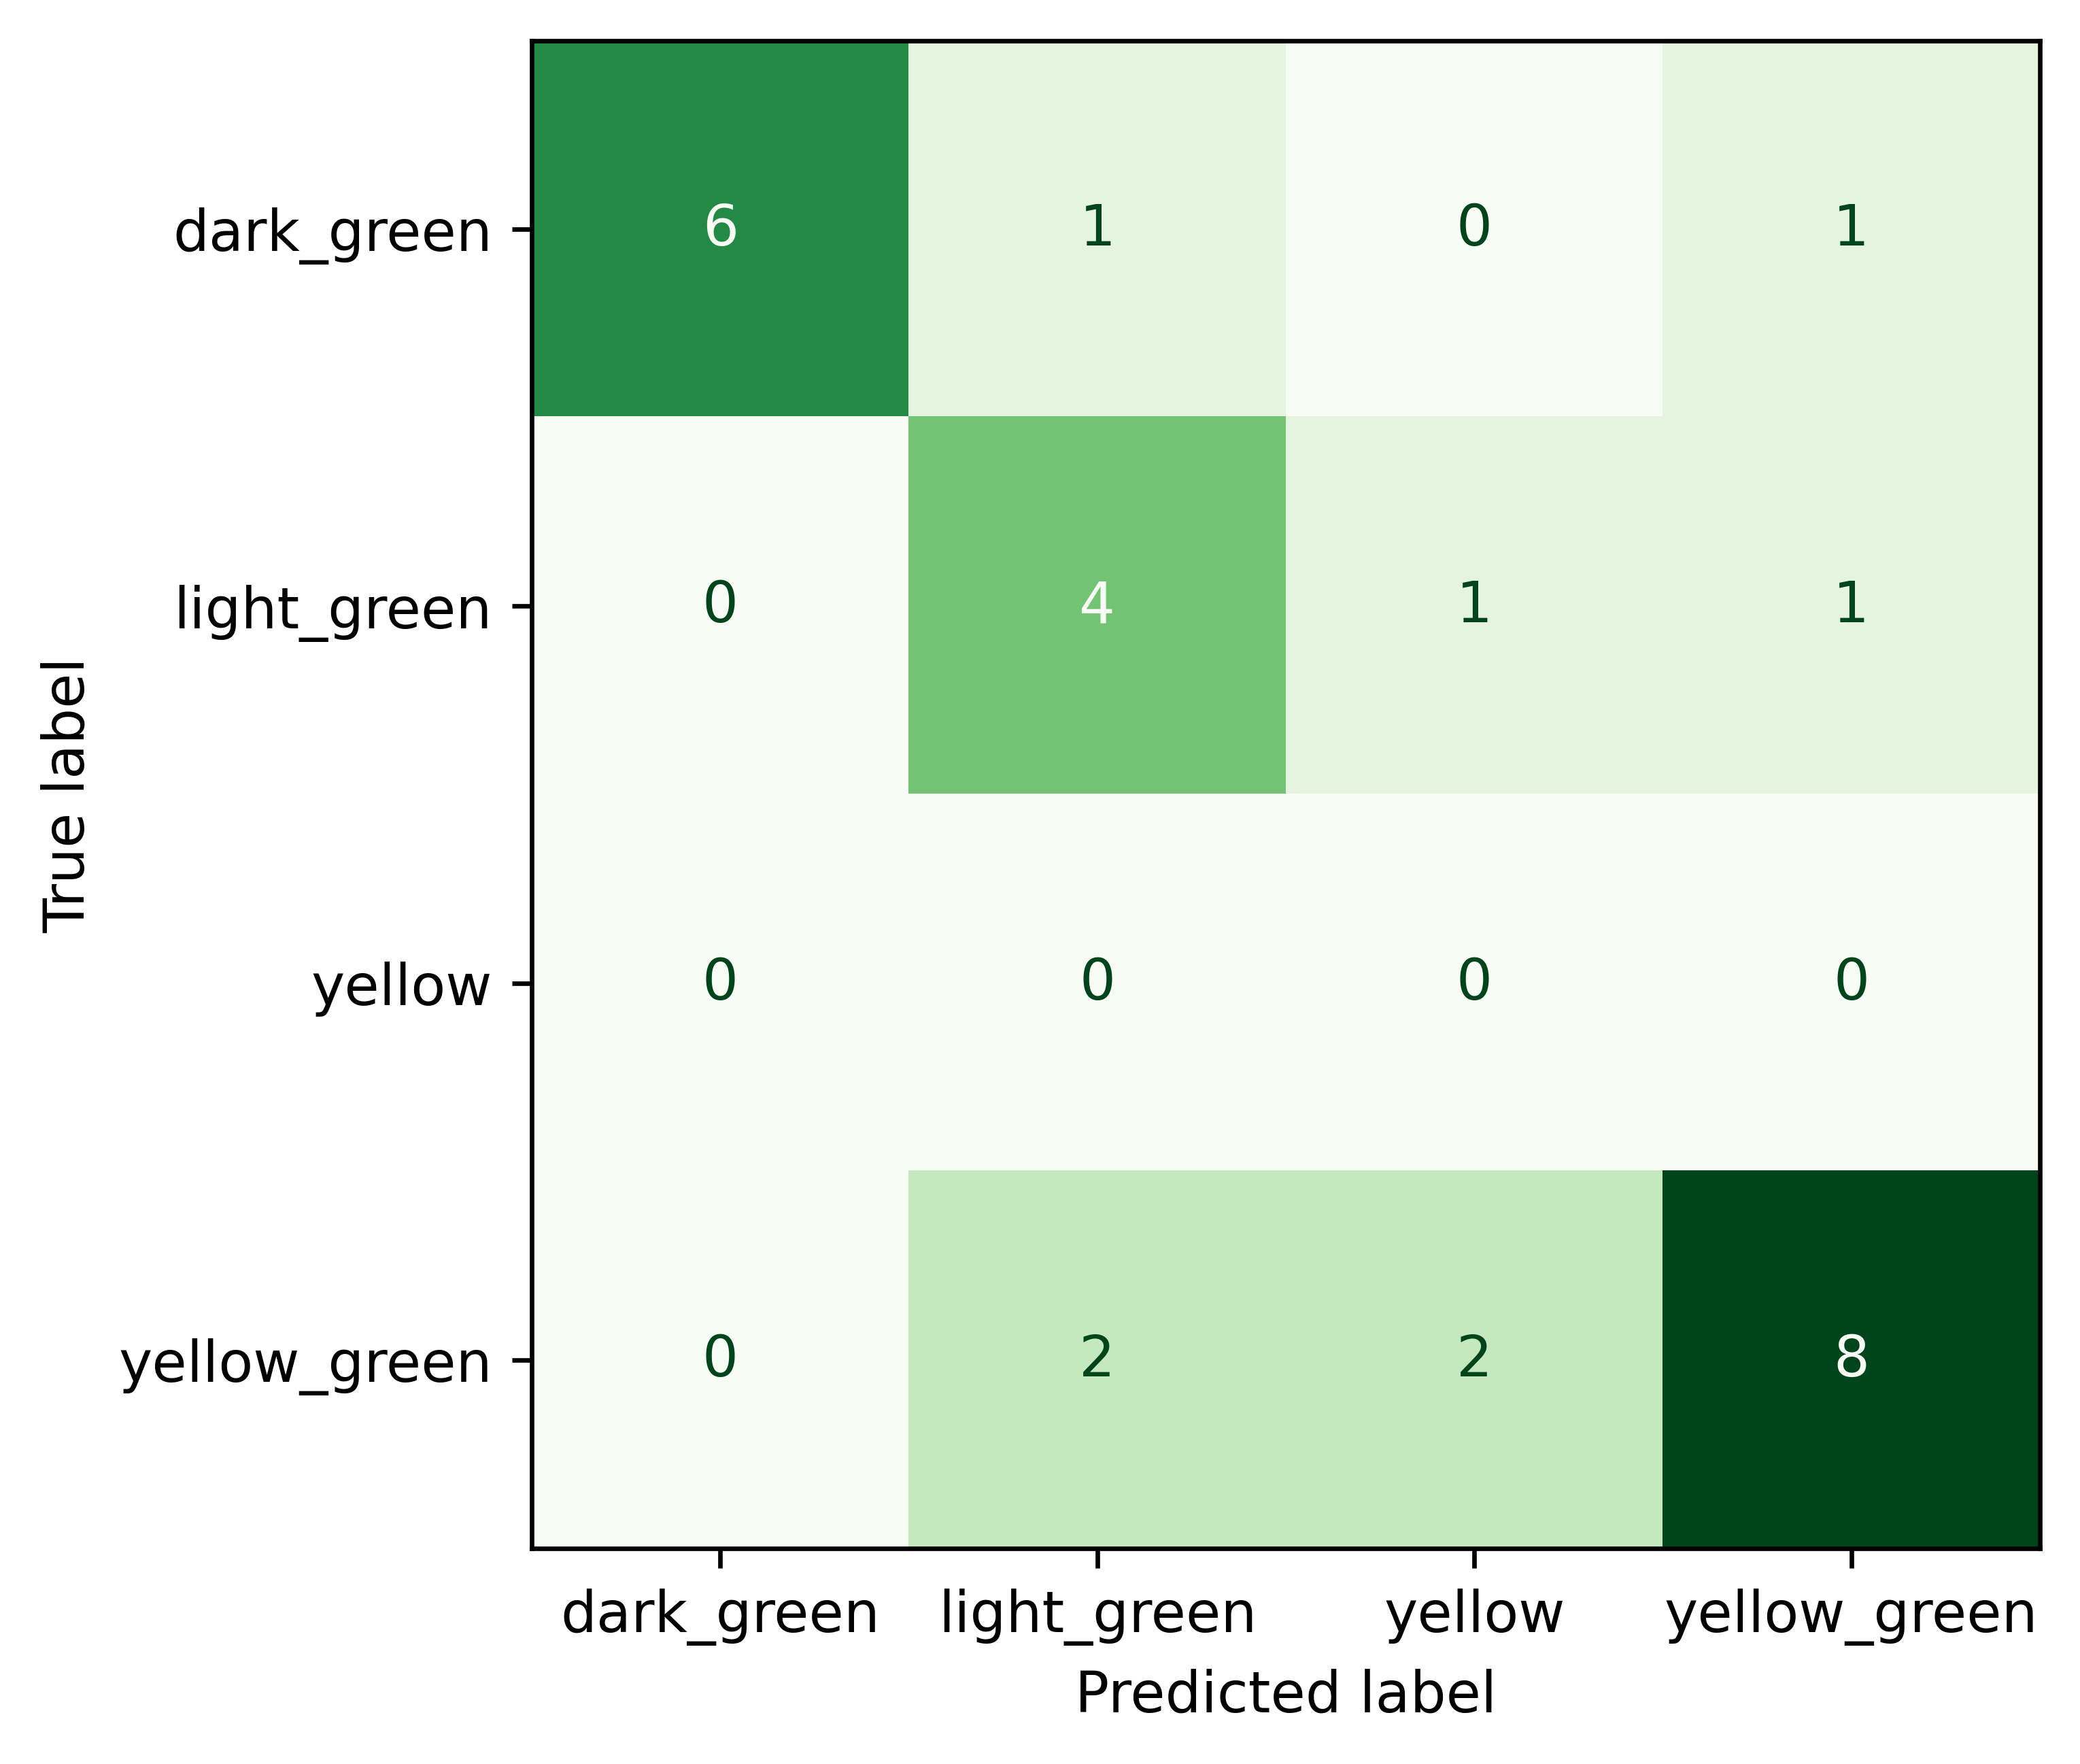

In [24]:
encoder = encoders['color']
cm = confusion_matrix(y_test[:, 0], y_pred[:, 0])
disp = ConfusionMatrixDisplay(cm, display_labels=encoder.inverse_transform([0, 1, 2, 3]))
disp.plot(cmap="Greens", colorbar=False)
plt.show()

Confusion Matrix for Leaf Shapes

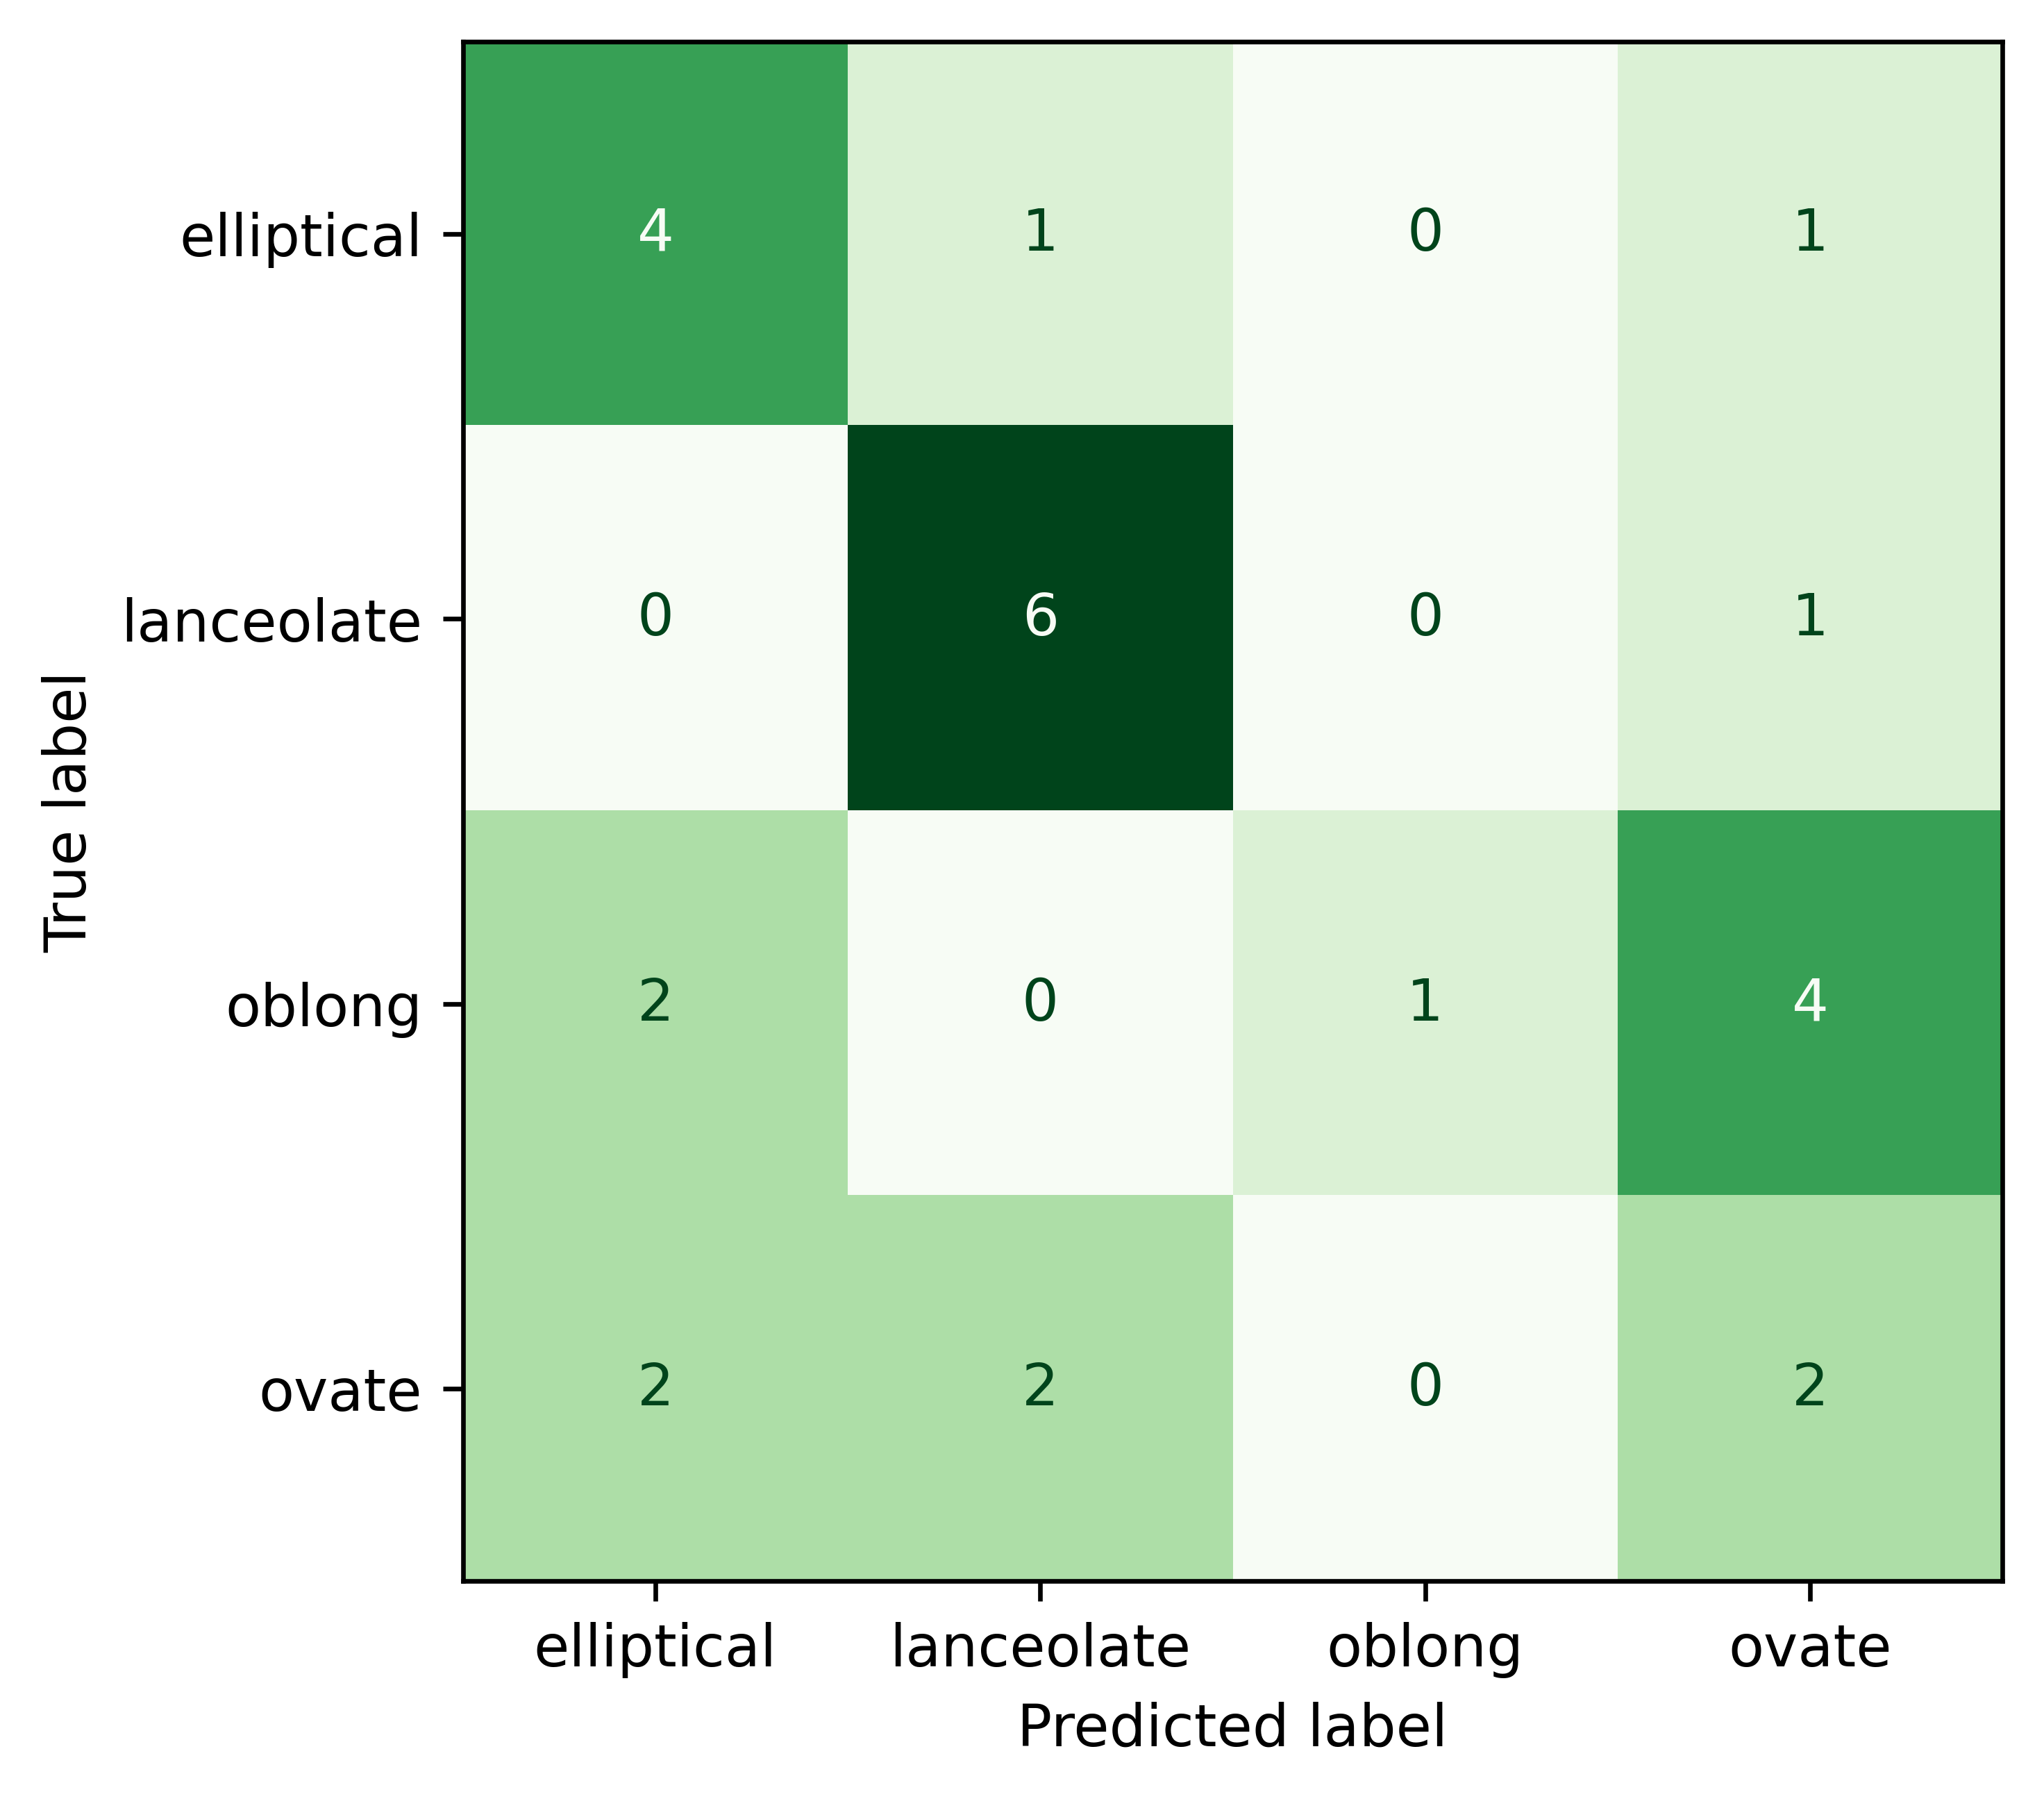

In [26]:
encoder = encoders['shape']
cm = confusion_matrix(y_test[:, 1], y_pred[:, 1])
disp = ConfusionMatrixDisplay(cm, display_labels=encoder.inverse_transform([0, 1, 2, 3]))
disp.plot(cmap="Greens", colorbar=False)
plt.show()

Confusion Matrix for Brown Splotch Level

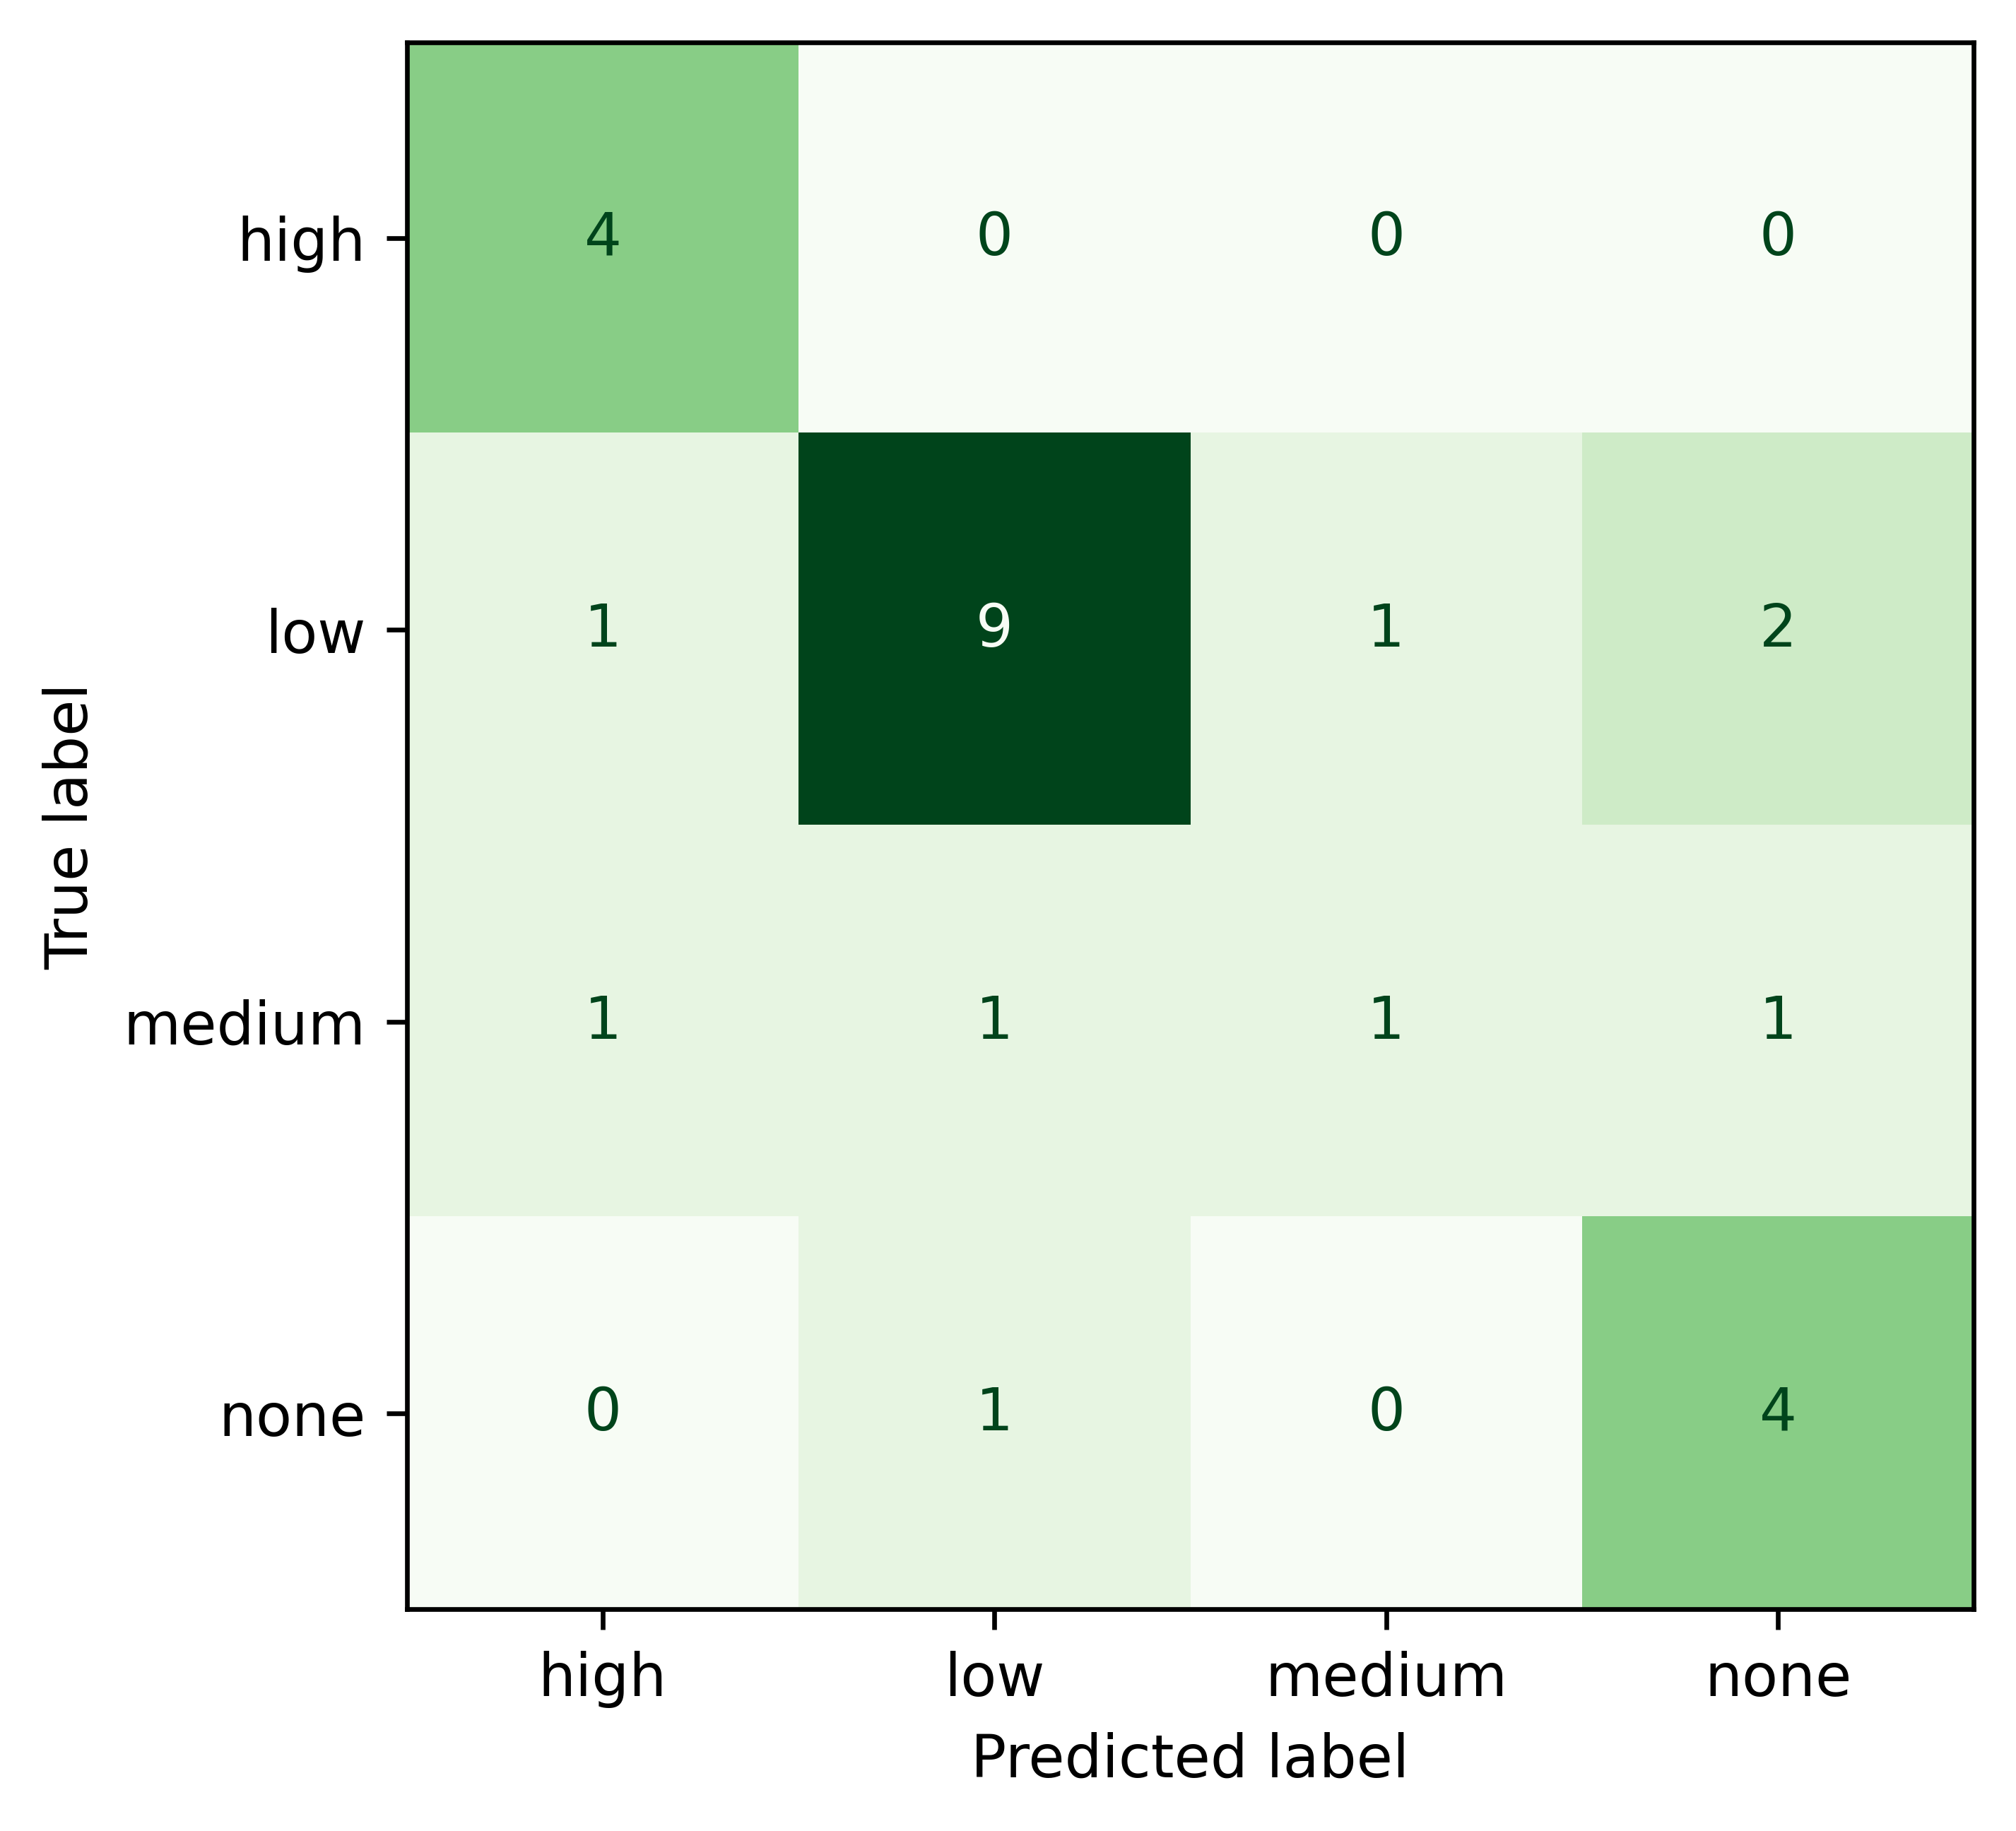

In [25]:
encoder = encoders['splotch']
cm = confusion_matrix(y_test[:, 2], y_pred[:, 2])
disp = ConfusionMatrixDisplay(cm, display_labels=encoder.inverse_transform([0, 1, 2, 3]))
disp.plot(cmap="Greens", colorbar=False)
plt.show()